In [2]:
!pip install torch torchvision torchaudio
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
!pip install networkx matplotlib psutil


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
pip uninstall torch-scatter -y


Found existing installation: torch-scatter 2.1.2+pt20cpu
Uninstalling torch-scatter-2.1.2+pt20cpu:
  Successfully uninstalled torch-scatter-2.1.2+pt20cpu


In [6]:
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 18.0 MB/s eta 0:00:00


In [7]:
pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.2 MB/s eta 0:00:00


<ipython-input-8-6a099c6759cd>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  coords_tensor = torch.tensor(coords, dtype=torch.float)


Average pLDDT from PDB: 87.31


<ipython-input-8-6a099c6759cd>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


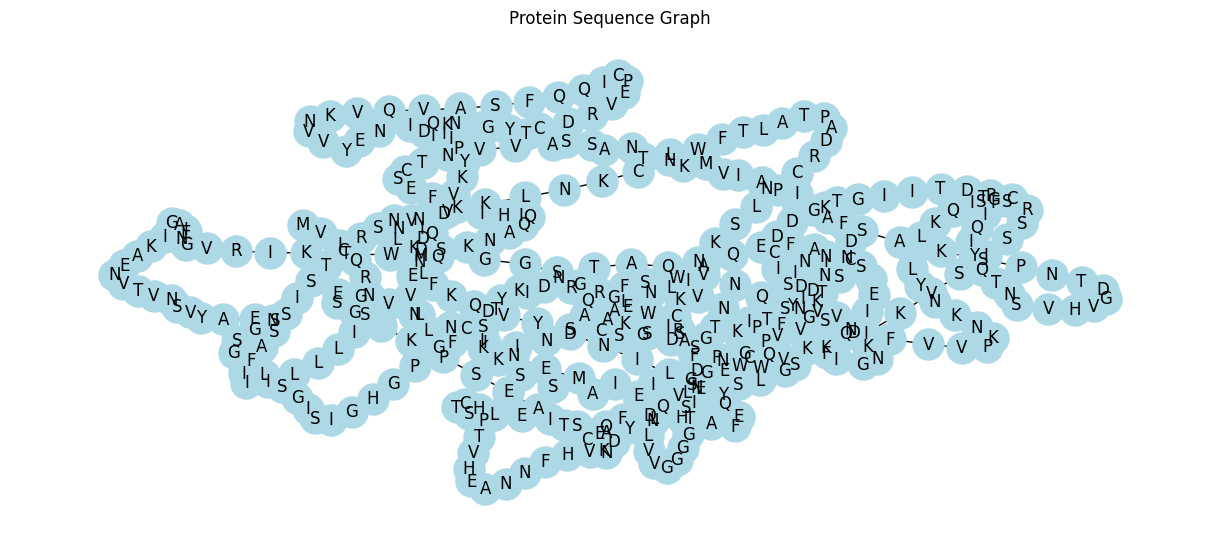

Graph saved to protein_graph.png
Epoch 0 | Loss: 216.0616
Epoch 10 | Loss: 215.6260
Epoch 20 | Loss: 215.1779
Epoch 30 | Loss: 214.7061
Epoch 40 | Loss: 214.1885
Epoch 50 | Loss: 213.6167
Epoch 60 | Loss: 212.9804
Epoch 70 | Loss: 212.2829
Epoch 80 | Loss: 211.5419
Epoch 90 | Loss: 210.7632
RMSD between predicted and ground truth: 25.1020
Coordinates saved to predicted_coordinates_with_plddt.csv
Scores saved to evaluation_scores.csv

--- Performance Metrics ---
Elapsed time       : 29.90 seconds
Start memory (RAM) : 809.14 MB
End memory (RAM)   : 816.36 MB
Peak memory (heap) : 189.63 MB
Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.


In [8]:
# === Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
import pickle
import csv
import time
import tracemalloc
import psutil
import os

# === Encoding ===
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_dict = {aa: i for i, aa in enumerate(amino_acids)}

def encode_sequence(seq):
    vec = []
    for aa in seq:
        one_hot = [0] * 20
        if aa in aa_dict:
            one_hot[aa_dict[aa]] = 1
        vec.append(one_hot)
    return torch.tensor(vec, dtype=torch.float)

def create_edges(n):
    edges = [[i, i + 1] for i in range(n - 1)]
    edges += [[i + 1, i] for i in range(n - 1)]
    return torch.tensor(edges, dtype=torch.long).t()

# === GNN Model ===
class StructureGNN(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64):
        super(StructureGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 3)  # output 3D coordinates

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# === Load Ground Truth CA Coordinates and pLDDT ===
def get_ca_coordinates_and_plddt_with_indices(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = []
    plddt_scores = []
    indices = []
    for i, residue in enumerate(structure[0]["A"]):
        if "CA" in residue:
            ca_atom = residue["CA"]
            coords.append(ca_atom.coord)
            plddt_scores.append(ca_atom.get_bfactor())
            indices.append(i)
    coords_tensor = torch.tensor(coords, dtype=torch.float)
    return coords_tensor, plddt_scores, indices

# === Graph Creation ===
def generate_graph(sequence):
    x = encode_sequence(sequence)
    edge_index = create_edges(len(sequence))
    data = Data(x=x, edge_index=edge_index)

    G = nx.Graph()
    for i, aa in enumerate(sequence):
        G.add_node(i, label=aa)
    for src, dst in edge_index.t().tolist():
        G.add_edge(src, dst)
    return G, data

# === RMSD Calculation ===
def calculate_rmsd(predicted, target):
    assert predicted.shape == target.shape, "Shape mismatch for RMSD calculation"
    diff = predicted - target
    rmsd = torch.sqrt(torch.mean(torch.sum(diff ** 2, dim=1)))
    return rmsd.item()

# === Training Loop ===
def train_structure_gnn(data, target_coords, epochs=100, lr=0.001):
    model = StructureGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    data = data.to(device)
    target_coords = target_coords.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, target_coords)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return model, pred.detach().cpu()

# === Visualization Helper ===
def visualize_graph(G, sequence, save_path="protein_graph.png"):
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G, seed=42)
    labels = {i: aa for i, aa in enumerate(sequence)}
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color='lightblue', node_size=500)
    plt.title("Protein Sequence Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Graph saved to {save_path}")

# === Save Coordinates to CSV with pLDDT ===
def save_coordinates_csv(coords, plddt_scores=None, filename="predicted_coordinates.csv"):
    coords_np = coords.numpy()
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        header = ["Residue_Index", "X", "Y", "Z"]
        if plddt_scores is not None:
            header.append("pLDDT")
        writer.writerow(header)

        for i, (x, y, z) in enumerate(coords_np):
            row = [i, x, y, z]
            if plddt_scores is not None and i < len(plddt_scores):
                row.append(plddt_scores[i])
            writer.writerow(row)
    print(f"Coordinates saved to {filename}")

def save_scores_csv(plddt, rmsd, filename="evaluation_scores.csv"):
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Average_pLDDT", "RMSD"])
        writer.writerow([plddt, rmsd])
    print(f"Scores saved to {filename}")

# === Main Execution ===
if __name__ == "__main__":
    # Start performance tracking
    start_time = time.time()
    tracemalloc.start()
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024 * 1024)  # MB

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sequence = "MVIQRNSILLLIIIFASSISTCRSNVIDDNLFKQVYDNILEQEFAHDFQAYLSYLSKNIE SNNNIDKVDKNGIKVINVLSFGAKGDGKTYDNIAFEQAWNEACSSRTPVQFVVPKNKNYL LKQITFSGPCRSSISVKIFGSLEASSKISDYKDRRLWIAFDSVQNLVVGGGGTINGNGQV WWPSSCKINKSLPCRDAPTALTFWNCKNLKVNNLKSKNAQQIHIKFESCTNVVASNLMIN ASAKSPNTDGVHVSNTQYIQISDTIIGTGDDCISIVSGSQNVQATNITCGPGHGISIGSL GSGNSEAYVSNVTVNEAKIIGAENGVRIKTWQGGSGQASNIKFLNVEMQDVKYPIIIDQN YCDRVEPCIQQFSAVQVKNVVYENIKGTSATKVAIKFDCSTNFPCEGIIMENINLVGESG KPSEATCKNVHFNNAEHVTPHCTSLEISEDEALLYNY"
    pdb_file = "/content/drive/MyDrive/tomato_GT/AF-P05117-F1-model_v4.pdb"

    coords_gt, plddt_scores, valid_indices = get_ca_coordinates_and_plddt_with_indices(pdb_file)
    filtered_sequence = ''.join([sequence[i] for i in valid_indices])

    avg_plddt = sum(plddt_scores) / len(plddt_scores)
    print(f"Average pLDDT from PDB: {avg_plddt:.2f}")

    G, data = generate_graph(filtered_sequence)
    visualize_graph(G, filtered_sequence)

    model, pred_coords = train_structure_gnn(data, coords_gt)
    rmsd_score = calculate_rmsd(pred_coords, coords_gt)
    print(f"RMSD between predicted and ground truth: {rmsd_score:.4f}")

    save_coordinates_csv(pred_coords, plddt_scores, "predicted_coordinates_with_plddt.csv")
    save_scores_csv(avg_plddt, rmsd_score, "evaluation_scores.csv")

    # Save artifacts
    torch.save(data, "structure_data.pt")
    torch.save(model.state_dict(), "structure_gnn.pth")
    np.save("predicted_coords.npy", pred_coords.numpy())
    with open("structure_graph.gpickle", "wb") as f:
        pickle.dump(G, f)

    # End performance tracking
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_time = time.time()
    end_mem = process.memory_info().rss / (1024 * 1024)  # MB

    print(f"\n--- Performance Metrics ---")
    print(f"Elapsed time       : {end_time - start_time:.2f} seconds")
    print(f"Start memory (RAM) : {start_mem:.2f} MB")
    print(f"End memory (RAM)   : {end_mem:.2f} MB")
    print(f"Peak memory (heap) : {peak / (1024 * 1024):.2f} MB")

    if torch.cuda.is_available():
        print(f"Max CUDA memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")

    print("Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.")


Average pLDDT from PDB: 96.12


<ipython-input-9-120879e5ce78>:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


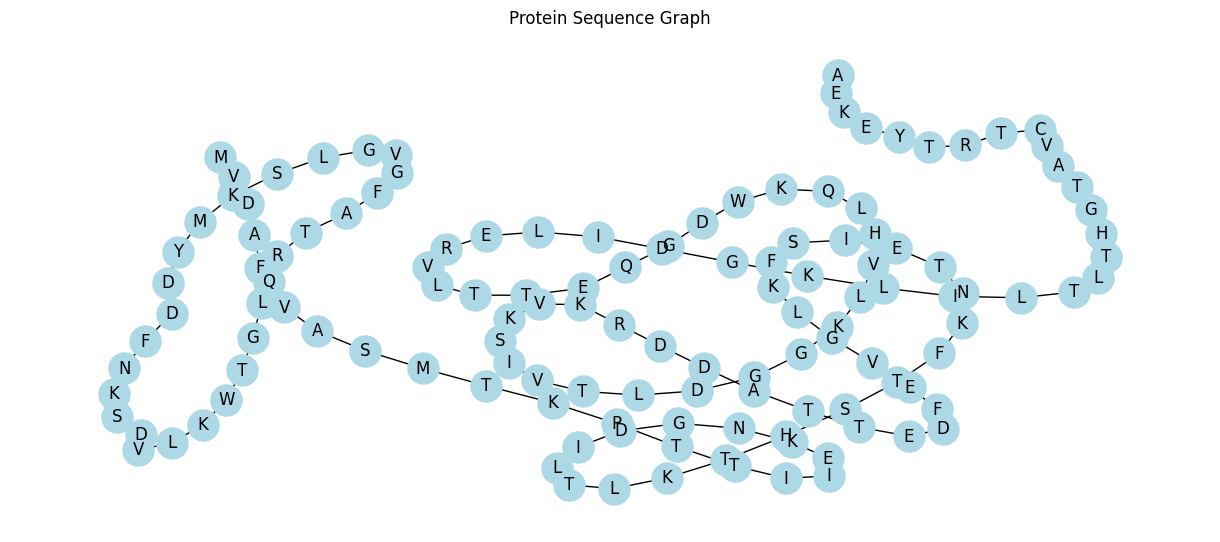

Graph saved to protein_graph.png
Epoch 0 | Loss: 68.0118
Epoch 10 | Loss: 67.6572
Epoch 20 | Loss: 67.3192
Epoch 30 | Loss: 66.9813
Epoch 40 | Loss: 66.6229
Epoch 50 | Loss: 66.2336
Epoch 60 | Loss: 65.8036
Epoch 70 | Loss: 65.3172
Epoch 80 | Loss: 64.7740
Epoch 90 | Loss: 64.1819
RMSD between predicted and ground truth: 13.8145
Coordinates saved to predicted_coordinates_with_plddt.csv
Scores saved to evaluation_scores.csv

--- Performance Metrics ---
Elapsed time       : 5.12 seconds
Start memory (RAM) : 816.36 MB
End memory (RAM)   : 821.00 MB
Peak memory (heap) : 3.32 MB
Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
import pickle
import csv
import time
import tracemalloc
import psutil
import os

# === Encoding ===
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_dict = {aa: i for i, aa in enumerate(amino_acids)}

def encode_sequence(seq):
    vec = []
    for aa in seq:
        one_hot = [0] * 20
        if aa in aa_dict:
            one_hot[aa_dict[aa]] = 1
        vec.append(one_hot)
    return torch.tensor(vec, dtype=torch.float)

def create_edges(n):
    edges = [[i, i + 1] for i in range(n - 1)]
    edges += [[i + 1, i] for i in range(n - 1)]
    return torch.tensor(edges, dtype=torch.long).t()

# === GNN Model ===
class StructureGNN(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64):
        super(StructureGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 3)  # output 3D coordinates

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# === Load Ground Truth CA Coordinates and pLDDT from PDB ===
def get_ca_coordinates_and_plddt(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = []
    plddt_scores = []
    for residue in structure[0]["A"]:  # assumes chain A
        if "CA" in residue:
            ca_atom = residue["CA"]
            coords.append(ca_atom.coord)
            plddt_scores.append(ca_atom.get_bfactor())  # pLDDT stored in B-factor
    coords_tensor = torch.tensor(coords, dtype=torch.float)
    return coords_tensor, plddt_scores

# === Graph Creation ===
def generate_graph(sequence):
    x = encode_sequence(sequence)
    edge_index = create_edges(len(sequence))
    data = Data(x=x, edge_index=edge_index)

    G = nx.Graph()
    for i, aa in enumerate(sequence):
        G.add_node(i, label=aa)
    for src, dst in edge_index.t().tolist():
        G.add_edge(src, dst)
    return G, data

# === RMSD Calculation ===
def calculate_rmsd(predicted, target):
    assert predicted.shape == target.shape, "Shape mismatch for RMSD calculation"
    diff = predicted - target
    rmsd = torch.sqrt(torch.mean(torch.sum(diff ** 2, dim=1)))
    return rmsd.item()

# === Training Loop ===
def train_structure_gnn(data, target_coords, epochs=100, lr=0.001):
    model = StructureGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    data = data.to(device)
    target_coords = target_coords.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, target_coords)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return model, pred.detach().cpu()

# === Visualization Helper ===
def visualize_graph(G, sequence, save_path="protein_graph.png"):
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G, seed=42)
    labels = {i: aa for i, aa in enumerate(sequence)}
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color='lightblue', node_size=500)
    plt.title("Protein Sequence Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Graph saved to {save_path}")

# === Save Coordinates to CSV with pLDDT ===
def save_coordinates_csv(coords, plddt_scores=None, filename="predicted_coordinates.csv"):
    coords_np = coords.numpy()
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        header = ["Residue_Index", "X", "Y", "Z"]
        if plddt_scores is not None:
            header.append("pLDDT")
        writer.writerow(header)

        for i, (x, y, z) in enumerate(coords_np):
            row = [i, x, y, z]
            if plddt_scores is not None and i < len(plddt_scores):
                row.append(plddt_scores[i])
            writer.writerow(row)
    print(f"Coordinates saved to {filename}")

# === Save Scores to CSV ===
def save_scores_csv(plddt, rmsd, filename="evaluation_scores.csv"):
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Average_pLDDT", "RMSD"])
        writer.writerow([plddt, rmsd])
    print(f"Scores saved to {filename}")

# === Main Execution ===
if __name__ == "__main__":
    # Start performance tracking
    start_time = time.time()
    tracemalloc.start()
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024 * 1024)  # MB

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Input protein sequence and PDB file path
    sequence = "MVDAFLGTWKLVDSKNFDDYMKSLGVGFATRQVASMTKPTTIIEKNGDILTLKTHSTFKNTEISFKLGVEFDETTADDRKVKSIVTLDGGKLVHLQKWDGQETTLVRELIDGKLILTLTHGTAVCTRTYEKEA"
    pdb_file = "/content/drive/MyDrive/human_based_GT/AF-P05413-F1-model_v4.pdb"

    coords_gt, plddt_scores = get_ca_coordinates_and_plddt(pdb_file)
    avg_plddt = sum(plddt_scores) / len(plddt_scores)
    print(f"Average pLDDT from PDB: {avg_plddt:.2f}")

    # === Fix size mismatch by trimming sequence ===
    if len(sequence) > coords_gt.shape[0]:
        print(f"Trimming sequence from {len(sequence)} to {coords_gt.shape[0]}")
        sequence = sequence[:coords_gt.shape[0]]

    G, data = generate_graph(sequence)
    visualize_graph(G, sequence)

    model, pred_coords = train_structure_gnn(data, coords_gt)
    rmsd_score = calculate_rmsd(pred_coords, coords_gt)
    print(f"RMSD between predicted and ground truth: {rmsd_score:.4f}")

    save_coordinates_csv(pred_coords, plddt_scores, "predicted_coordinates_with_plddt.csv")
    save_scores_csv(avg_plddt, rmsd_score, "evaluation_scores.csv")

    # Save other artifacts
    torch.save(data, "structure_data.pt")
    torch.save(model.state_dict(), "structure_gnn.pth")
    np.save("predicted_coords.npy", pred_coords.numpy())
    with open("structure_graph.gpickle", "wb") as f:
        pickle.dump(G, f)

    # End performance tracking
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_time = time.time()
    end_mem = process.memory_info().rss / (1024 * 1024)  # MB

    print(f"\n--- Performance Metrics ---")
    print(f"Elapsed time       : {end_time - start_time:.2f} seconds")
    print(f"Start memory (RAM) : {start_mem:.2f} MB")
    print(f"End memory (RAM)   : {end_mem:.2f} MB")
    print(f"Peak memory (heap) : {peak / (1024 * 1024):.2f} MB")

    if torch.cuda.is_available():
        print(f"Max CUDA memory allocated: {torch.cuda.max_memory_allocated() / (1024 ** 2):.2f} MB")

    print("Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.")


Average pLDDT from PDB: 87.24


<ipython-input-11-101bad0ebd35>:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


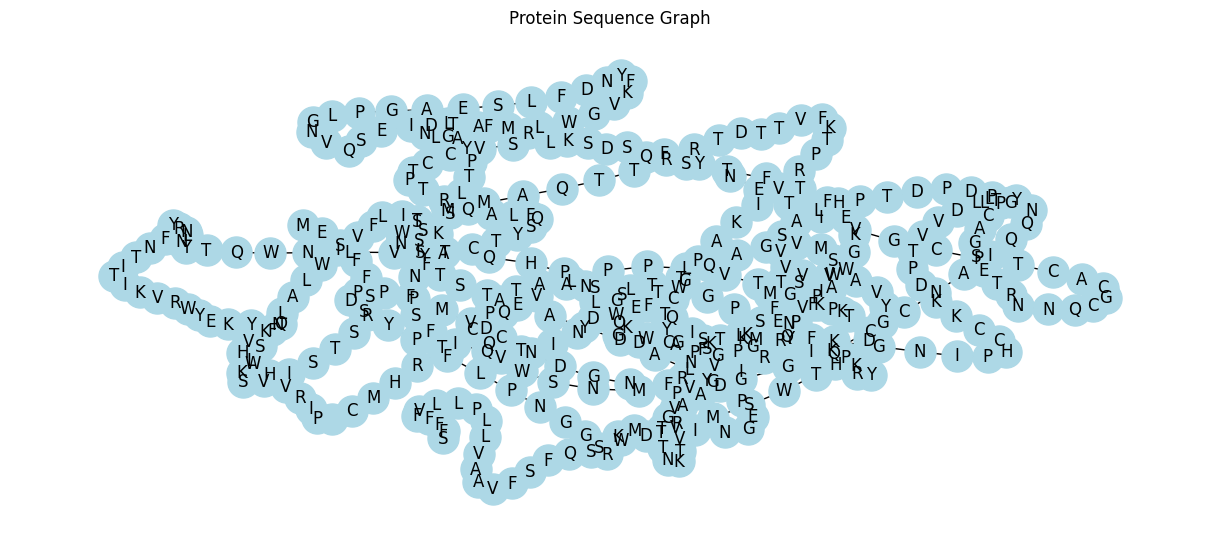

Graph saved to protein_graph.png
Epoch 0 | Loss: 330.2313
Epoch 10 | Loss: 329.4874
Epoch 20 | Loss: 328.7870
Epoch 30 | Loss: 328.0854
Epoch 40 | Loss: 327.3467
Epoch 50 | Loss: 326.5349
Epoch 60 | Loss: 325.6255
Epoch 70 | Loss: 324.6057
Epoch 80 | Loss: 323.4615
Epoch 90 | Loss: 322.1858
RMSD between predicted and ground truth: 31.0286
Coordinates saved to predicted_coordinates_with_plddt.csv
Scores saved to evaluation_scores.csv

Performance Metrics:
Elapsed Time: 8.67 seconds
Start Memory: 835.95 MB
End Memory: 836.46 MB
Peak Memory (Heap): 16.58 MB


In [11]:
import time
import tracemalloc
import psutil
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
import pickle
import csv

# === Encoding ===
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_dict = {aa: i for i, aa in enumerate(amino_acids)}

def encode_sequence(seq):
    vec = []
    for aa in seq:
        one_hot = [0] * 20
        if aa in aa_dict:
            one_hot[aa_dict[aa]] = 1
        vec.append(one_hot)
    return torch.tensor(vec, dtype=torch.float)

def create_edges(n):
    edges = [[i, i + 1] for i in range(n - 1)]
    edges += [[i + 1, i] for i in range(n - 1)]
    return torch.tensor(edges, dtype=torch.long).t()

# === GNN Model ===
class StructureGNN(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64):
        super(StructureGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# === Load Ground Truth CA Coordinates and pLDDT ===
def get_ca_coordinates_and_plddt_with_indices(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords, plddt_scores, indices = [], [], []
    for i, residue in enumerate(structure[0]["A"]):
        if "CA" in residue:
            ca_atom = residue["CA"]
            coords.append(ca_atom.coord)
            plddt_scores.append(ca_atom.get_bfactor())
            indices.append(i)
    coords_tensor = torch.tensor(coords, dtype=torch.float)
    return coords_tensor, plddt_scores, indices

# === Graph Creation ===
def generate_graph(sequence):
    x = encode_sequence(sequence)
    edge_index = create_edges(len(sequence))
    data = Data(x=x, edge_index=edge_index)

    G = nx.Graph()
    for i, aa in enumerate(sequence):
        G.add_node(i, label=aa)
    for src, dst in edge_index.t().tolist():
        G.add_edge(src, dst)
    return G, data

# === RMSD Calculation ===
def calculate_rmsd(predicted, target):
    assert predicted.shape == target.shape, "Shape mismatch for RMSD calculation"
    diff = predicted - target
    rmsd = torch.sqrt(torch.mean(torch.sum(diff ** 2, dim=1)))
    return rmsd.item()

# === Training Loop ===
def train_structure_gnn(data, target_coords, epochs=100, lr=0.001):
    model = StructureGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    data = data.to(device)
    target_coords = target_coords.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, target_coords)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return model, pred.detach().cpu()

# === Visualization ===
def visualize_graph(G, sequence, save_path="protein_graph.png"):
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G, seed=42)
    labels = {i: aa for i, aa in enumerate(sequence)}
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color='lightblue', node_size=500)
    plt.title("Protein Sequence Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Graph saved to {save_path}")

# === Save CSV ===
def save_coordinates_csv(coords, plddt_scores=None, filename="predicted_coordinates_with_plddt.csv"):
    coords_np = coords.numpy()
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        header = ["Residue_Index", "X", "Y", "Z"]
        if plddt_scores:
            header.append("pLDDT")
        writer.writerow(header)
        for i, (x, y, z) in enumerate(coords_np):
            row = [i, x, y, z]
            if plddt_scores and i < len(plddt_scores):
                row.append(plddt_scores[i])
            writer.writerow(row)
    print(f"Coordinates saved to {filename}")

def save_scores_csv(plddt, rmsd, filename="evaluation_scores.csv"):
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Average_pLDDT", "RMSD"])
        writer.writerow([plddt, rmsd])
    print(f"Scores saved to {filename}")

# === Main Execution ===
if __name__ == "__main__":
    # Start monitoring
    start_time = time.time()
    tracemalloc.start()
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024 ** 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence = "MESFFSRSTSIVSKLSFLALWIVFLISSSSFTSTEAYDALDPEGNITMKWDVMSWTPDGYVAVVTMFNFQKYRHIQSPGWTLGWKWAKKEVIWSMVGAQTTEQGDCSKYKGNIPHCCKKDPTVVDLLPGTPYNQQIANCCKGGVMNSWVQDPATAASSFQISVGAAGTTNKTVRVPRNFTLMGPGPGYTCGPAKIVRPTKFVTTDTRRTTQAMMTWNITCTYSQFLAQRTPTCCVSLSSFYNETIVGCPTCACGCQNNRTESGACLDPDTPHLASVVSPPTKKGTVLPPLVQCTRHMC PIRVHWHVKQNYKEYWRVKITITNFNYRLNYTQWNLVAQHPNLDNITQIFSFNYKSLTPYAGLNDTAMLWGVKFYNDFLSEAGPLGNVQSEILFRKDQSTFTFEKGWAFPRRIYFNGDNCVMPPPDSYPFLPNGGSRSQFSFVAAVLLPLLVFFFFSA"
    pdb_file = "/content/drive/MyDrive/cobra_GT/AF-Q94KT8-F1-model_v4 (2).pdb"

    coords_gt, plddt_scores, valid_indices = get_ca_coordinates_and_plddt_with_indices(pdb_file)
    filtered_sequence = ''.join([sequence[i] for i in valid_indices])
    avg_plddt = sum(plddt_scores) / len(plddt_scores)
    print(f"Average pLDDT from PDB: {avg_plddt:.2f}")

    G, data = generate_graph(filtered_sequence)
    visualize_graph(G, filtered_sequence)

    model, pred_coords = train_structure_gnn(data, coords_gt)

    rmsd_score = calculate_rmsd(pred_coords, coords_gt)
    print(f"RMSD between predicted and ground truth: {rmsd_score:.4f}")

    save_coordinates_csv(pred_coords, plddt_scores)
    save_scores_csv(avg_plddt, rmsd_score)

    torch.save(data, "structure_data.pt")
    torch.save(model.state_dict(), "structure_gnn.pth")
    np.save("predicted_coords.npy", pred_coords.numpy())
    with open("structure_graph.gpickle", "wb") as f:
        pickle.dump(G, f)

    # End monitoring
    end_time = time.time()
    end_mem = process.memory_info().rss / (1024 ** 2)
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"\nPerformance Metrics:")
    print(f"Elapsed Time: {end_time - start_time:.2f} seconds")
    print(f"Start Memory: {start_mem:.2f} MB")
    print(f"End Memory: {end_mem:.2f} MB")
    print(f"Peak Memory (Heap): {peak_mem / (1024 ** 2):.2f} MB")


Average pLDDT from PDB: 81.83


<ipython-input-11-101bad0ebd35>:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


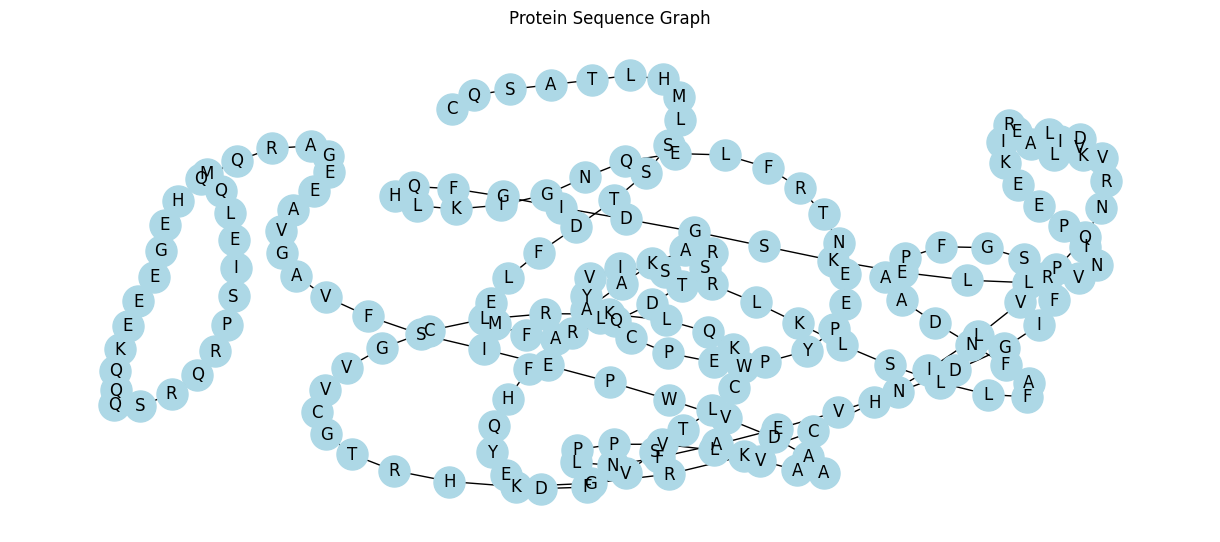

Graph saved to protein_graph.png
Epoch 0 | Loss: 111.0284
Epoch 10 | Loss: 110.5615
Epoch 20 | Loss: 110.1131
Epoch 30 | Loss: 109.6509
Epoch 40 | Loss: 109.1483
Epoch 50 | Loss: 108.5939
Epoch 60 | Loss: 107.9688
Epoch 70 | Loss: 107.2686
Epoch 80 | Loss: 106.4737
Epoch 90 | Loss: 105.5832
RMSD between predicted and ground truth: 17.7241
Coordinates saved to predicted_coordinates_with_plddt.csv
Scores saved to evaluation_scores.csv

Performance Metrics:
Elapsed Time: 4.13 seconds
Start Memory: 836.46 MB
End Memory: 836.98 MB
Peak Memory (Heap): 4.79 MB
Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.


In [12]:
import time
import tracemalloc
import psutil
import os

# === Main Execution with Monitoring ===
if __name__ == "__main__":
    # Start tracking
    start_time = time.time()
    tracemalloc.start()
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024 ** 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Input protein sequence and PDB file path
    sequence = "MQLEISPRQRSQQQKEEEGEHQQRAGEEAVGAVFSIEPWVDAAAVLVPPLNFAEVNDGIFRSGFPAADNFAFLLSLKLRSIVYLCPEPYPEENTRFLEQNGIKLHQFGIDGSKELLVNIPEEKIREALKVILDVRNQPVLIHCKRGKHRTGCVVGCLRKLQKWCLTSVFDEYQHFAAAKARSTDQRFMELFDTSSLMHLTASQC"
    pdb_file = "/content/drive/MyDrive/plant_based_GT/AF-Q0DX67-F1-model_v4.pdb"

    coords_gt, plddt_scores = get_ca_coordinates_and_plddt(pdb_file)
    avg_plddt = sum(plddt_scores) / len(plddt_scores)
    print(f"Average pLDDT from PDB: {avg_plddt:.2f}")

    G, data = generate_graph(sequence)
    visualize_graph(G, sequence)

    model, pred_coords = train_structure_gnn(data, coords_gt)

    rmsd_score = calculate_rmsd(pred_coords, coords_gt)
    print(f"RMSD between predicted and ground truth: {rmsd_score:.4f}")

    save_coordinates_csv(pred_coords, plddt_scores, "predicted_coordinates_with_plddt.csv")
    save_scores_csv(avg_plddt, rmsd_score, "evaluation_scores.csv")

    # Save artifacts
    torch.save(data, "structure_data.pt")
    torch.save(model.state_dict(), "structure_gnn.pth")
    np.save("predicted_coords.npy", pred_coords.numpy())
    with open("structure_graph.gpickle", "wb") as f:
        pickle.dump(G, f)

    # End tracking
    end_time = time.time()
    end_mem = process.memory_info().rss / (1024 ** 2)
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"\nPerformance Metrics:")
    print(f"Elapsed Time: {end_time - start_time:.2f} seconds")
    print(f"Start Memory: {start_mem:.2f} MB")
    print(f"End Memory: {end_mem:.2f} MB")
    print(f"Peak Memory (Heap): {peak_mem / (1024 ** 2):.2f} MB")

    print("Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.")
